In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/ubuntu/sustaingym


In [2]:
!ls

LICENSE		    env_norl.yml	  prices_and_soc_over_episode.png
README.md	    examples		  reward_over_epsiode.png
algo_comp_2019.png  model_PPO_2019_5.zip  sustaingym
algo_comp_2021.png  mypy.ini
env.yml		    notebooks


In [4]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.callbacks import EvalCallback, CallbackList, StopTrainingOnNoModelImprovement
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv



from sustaingym.envs import ElectricityMarketEnv
from sustaingym.envs.battery.plot_utils import plot_model_training_reward_curves, plot_reward_distribution, plot_state_of_charge_and_prices, plot_reward_over_episode, run_model_for_evaluation

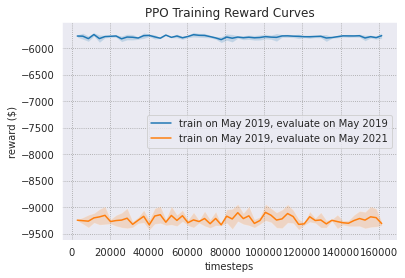

In [4]:
ax = plot_model_training_reward_curves(None, 'PPO', ['in_dist', 'out_dist'])

plt.savefig('examples/logs_PPO/ppo_reward_curves.png', dpi=300)

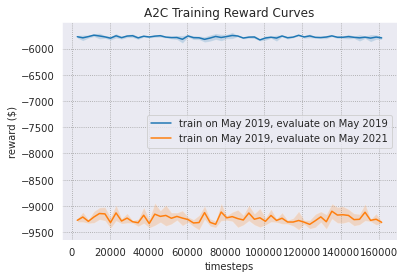

In [5]:
ax = plot_model_training_reward_curves(None, 'A2C', ['in_dist', 'out_dist'])

plt.savefig('examples/logs_A2C/a2c_reward_curves.png', dpi=300)

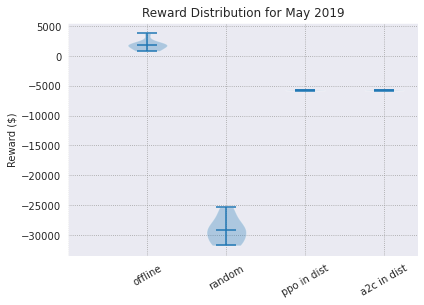

In [7]:
env_2019 = ElectricityMarketEnv(month='2019-05', seed=195)

ppo = PPO.load('examples/model_PPO_2019_5.zip')
a2c = A2C.load('examples/model_A2C_2019_5.zip')

ax = plot_reward_distribution(None, env_2019, [ppo, a2c],
    ['ppo in dist', 'a2c in dist'], 10, '2019')

plt.xticks(rotation=30)

plt.savefig('algo_comp_2019.png', dpi=300)



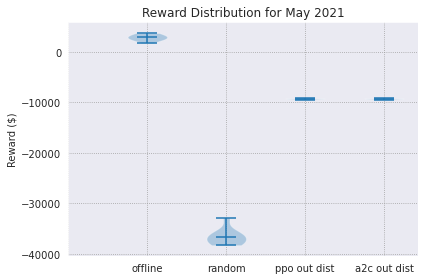

In [8]:
env_2021 = BatteryStorageInGridEnv(month='2021-05', seed=215)

ppo = PPO.load('examples/model_PPO_2019_5.zip')
a2c = A2C.load('examples/model_A2C_2019_5.zip')

ax = plot_reward_distribution(None, env_2021, [ppo, a2c],
    ['ppo out dist', 'a2c out dist'], 10, '2021')

plt.savefig('algo_comp_2021.png', dpi=300)

state of charge:  [6.00000000e+01 5.58333321e+01 5.16666641e+01 4.74999962e+01
 4.33333282e+01 3.91666603e+01 3.49999924e+01 3.08333263e+01
 2.66666603e+01 2.24999943e+01 1.83333282e+01 1.41666613e+01
 9.99999428e+00 5.83332777e+00 1.66666114e+00 3.97359550e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

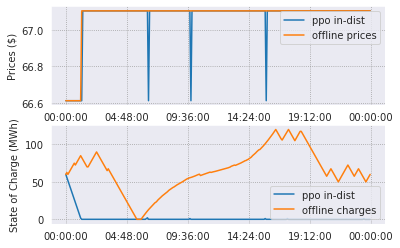

In [5]:
import datetime
import gym
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

class DiscreteActions(gym.ActionWrapper):
    def __init__(self, env: ElectricityMarketEnv):
        super().__init__(env)
        self.env = env
        self.charge_action = (env.action_space.high[0], env.action_space.high[0])
        self.discharge_action = (0.01*env.action_space.high[0], 0.01*env.action_space.high[0])
        self.action_space = gym.spaces.Discrete(2)
    
    def action(self, action: int):
        assert action in [0, 1]
        if action == 0:
            return self.charge_action
        else:
            return self.discharge_action
    
    def _calculate_prices_without_agent(self) -> np.ndarray:
        return self.env._calculate_prices_without_agent()
    
    def _calculate_price_taking_optimal(
            self, prices: np.ndarray, init_charge: float,
            final_charge: float) -> tuple[float, np.ndarray]:
        return self.env._calculate_price_taking_optimal(prices, init_charge, final_charge)
    
    def _calculate_terminal_cost(self, agent_battery_charge: float) -> float:
        return self.env._caculate_terminal_cost(agent_battery_charge)

df_load = pd.read_csv('sustaingym/data/demand_data/CAISO-demand-2019-05.csv.gz', compression='gzip', index_col=0)

env = ElectricityMarketEnv(month='2019-05', seed=195)
env = DiscreteActions(env)

dqn = DQN.load('examples/discrete_model_DQN_2019_5.zip')

ax, ax2 = plot_state_of_charge_and_prices(None, df_load, dqn, 'ppo in-dist', env)

plt.savefig('prices_and_soc_over_episode.png', dpi=300)

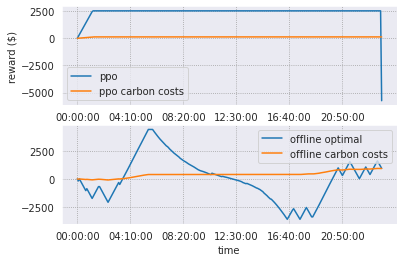

In [5]:
env = ElectricityMarketEnv(month='2019-05', seed=195)
env = DiscreteActions(env)
ppo = PPO.load('examples/discrete_model_PPO_2019_5.zip')

ax, ax2 = plot_reward_over_episode(None, ppo, env)

plt.savefig('reward_over_epsiode.png', dpi=300)